## Review
### This recitation (11.22) covers two following lectures below:
- **11.15 (Wed)**
- **11.20 (Wed)**


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from collections import defaultdict

Define some helpful functions!

In [ ]:
def init_orthogonal(param):
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    rows, cols = param.shape
    new_param = np.random.randn(rows, cols)
    if rows < cols:
        new_param = new_param.T

    q, r = np.linalg.qr(new_param)
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T

    new_param = q
    return new_param

def clip_gradient_norm(grads, max_norm=0.25):
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0

    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm

    total_norm = np.sqrt(total_norm)

    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)

    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    return grads

### RNN

![rnn-unroll image](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/rnn-unfold.png?raw=1)

- $x$ is the input sequence of samples,
- $U$ is a weight matrix applied to the given input sample,
- $V$ is a weight matrix used for the recurrent computation in order to pass memory along the sequence,
- $W$ is a weight matrix used to compute the output of the every timestep (given that every timestep requires an output),
- $h$ is the hidden state (the network's memory) for a given time step, and
- $o$ is the resulting output.

When the network is unrolled as shown, it is easier to refer to a timestep, $t$.
We have the following computations through the network:

- $h_t = f(U\,{x_t} + V\,{h_{t-1}})$, where $f$ usually is an activation function, e.g. $\mathrm{tanh}$.
- $o_t = \mathrm{softmax}(W\,{h_t})$

**In this recitation, we will implement the whole (forward/backward and training) process of the above image!**

### RNN Variants

<img src="https://drive.google.com/uc?export=view&id=17Zbuh5eYyq8SCSDZnlnWaFzwvO0ULhZ2" alt="Drawing" height=300 />



1.   **RNN** : A recurrent neural network is a type of artificial neural network commonly used in speech recognition and natural language processing. Recurrent neural networks recognize data's sequential characteristics and use patterns to predict the next likely scenario.


2.   **LSTM** : Long Short Term Memory (LSTMs) are predominantly used to learn, process, and classify sequential data because these networks can learn long-term dependencies between time steps of data.


3.   **GRU** : Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a gating mechanism to input or forget certain features, but lacks a context vector or output gate, resulting in fewer parameters than LSTM.




## Build RNNs

In this recitation, we will introduce a way of learning from **sequential data**. As an example, we will train a neural network to do language modelling, i.e. predict the next token in a sentence.

### Generate sequence dataset

To build and train our RNN, we will create a simple dataset that we can learn from. We generate sequences of the form:

`E E E E X X X X  EOS`

`E E X X  EOS`

`E E E E E X X X X X EOS`

where EOS refers **E**nd **O**f the **S**equence.

In [ ]:
np.random.seed(20231122)

def generate_dataset(num_sequences=100):

    samples = []
    for _ in range(num_sequences):
        num_tokens = np.random.randint(1, 10)
        sample = ['E'] * num_tokens + ['X'] * num_tokens + ['EOS']
        samples.append(sample)

    return samples


sequences = generate_dataset()

print('A sample from the generated dataset:')
print(sequences[0])

A sample from the generated dataset:
['E', 'E', 'E', 'E', 'E', 'X', 'X', 'X', 'X', 'X', 'EOS']


### Preprocessing

Now, we made our on sequence dataset. we are going to make a **dictionary** using tokens in dataset and perform **one-hot encoding**.

#### Make dictionary

In [ ]:
# preprocessing 1 : dictionary
def sequences_to_dicts(sequences):

    # A bit of Python-magic to flatten a nested list
    flatten = lambda l: [item for sublist in l for item in sublist]

    # Flatten the dataset
    all_words = flatten(sequences)

    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])

    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]

    # Add UNK token to list of words
    unique_words.append('UNK')

    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)

    # Create dictionaries so that we can go from word to index and back
    # If a word is not in our vocabulary, we assign it to token 'UNK'
    num_words = len(unique_words)
    word_to_idx = defaultdict(lambda: num_words)
    idx_to_word = defaultdict(lambda: 'UNK')

    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        # YOUR CODE HERE!
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'We have {num_sequences} sentences and {len(word_to_idx)} unique tokens in our dataset (E, X, EOS, UNK).\n')
print('The index of \'X\' is', word_to_idx['X'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

We have 100 sentences and 4 unique tokens in our dataset (E, X, EOS, UNK).

The index of 'X' is 1
The word corresponding to index 1 is 'X'


#### One-hot encoding

<img src="https://drive.google.com/uc?export=view&id=1ZJqfIKo5nTSoD-3D0EXJrWcz2cThqzob" alt="Drawing" height=300 />

**One-hot encoding** in machine learning is the conversion of categorical information into a format that may be fed into machine learning algorithms to improve prediction accuracy.

In [ ]:
# preprocessing 2 : one-hot encoding
def one_hot_encode(idx, vocab_size):

    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)

    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):

    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)

    return encoding


test_word = one_hot_encode(word_to_idx['E'], vocab_size)
print(f'Our one-hot encoding of \'E\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['E', 'X'], vocab_size)
print(f'Our one-hot encoding of \'E X\' has shape {test_sentence.shape}.')

Our one-hot encoding of 'E' has shape (4,).
Our one-hot encoding of 'E X' has shape (2, 4, 1).


#### DataLoader (pytorch)

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []

        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])

        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 80 samples in the training set.
We have 10 samples in the validation set.
We have 10 samples in the test set.


### Implement RNN components

We will implement the **(1) forward pass, (2) backward pass, (3) optimization** and **(4) training loop** for a RNN.

#### Initialize the RNN params

In [ ]:
hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used

def init_rnn(hidden_size, vocab_size):
    b_hidden = None
    b_out = None

    # Weight matrix (input to hidden state)
    # YOUR CODE HERE
    U = np.zeros((hidden_size, vocab_size))

    # Weight matrix (recurrent computation)
    # YOUR CODE HERE
    V = np.zeros((hidden_size, hidden_size))

    # Weight matrix (hidden state to output)
    # YOUR CODE HERE
    W = np.zeros((vocab_size, hidden_size))

    # Bias (hidden state)
    # YOUR CODE HERE
    b_hidden = np.zeros((hidden_size, 1))

    # Bias (output)
    # YOUR CODE HERE
    b_out = np.zeros((vocab_size, 1))

    # Initialize weights
    U = init_orthogonal(U)
    V = init_orthogonal(V)
    W = init_orthogonal(W)

    # Return parameters as a tuple
    return U, V, W, b_hidden, b_out


params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

#### Functions in RNN
Let's define the **sigmoid, tanh** and **softmax** functions. (Review)

In [ ]:
def sigmoid(x, derivative=False):
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))

    if derivative: # Backward
        return f * (1 - f)
    else: # Forward
        return f

In [ ]:
def tanh(x, derivative=False):
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    if derivative:  # Backward
        return 1-f**2
    else: # Forward
        return f

In [ ]:
def softmax(x, derivative=False):
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))

    if derivative: # Backward
        pass # We will not need this one
    else: # Forward
        return f

#### RNN Forward

Implement the forward pass of RNN.

In [ ]:
def forward_pass(inputs, hidden_state, params):

    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params

    # Create a list to store outputs and hidden states
    outputs, hidden_states = [], []

    # ---------------------------------------------------------------------------------------- #
    # For each element in input sequence
    for t in range(len(inputs)):

        # Compute new hidden state
        # YOUR CODE HERE
        hidden_state = tanh(np.dot(U, inputs[t]) + np.dot(V, hidden_state) + b_hidden)

        # Compute output
        # YOUR CODE HERE
        out = softmax(np.dot(W, hidden_state) + b_out)

        # Save results and continue
        outputs.append(out)
        hidden_states.append(hidden_state.copy())

    return outputs, hidden_states
    # --------------------------------------------------------------------------------------- #


## Inferecne with initialized params

# Get first sequence in training set
test_input_sequence, test_target_sequence = training_set[0]

# One-hot encode input and target sequence
test_input = one_hot_encode_sequence(test_input_sequence, vocab_size)
test_target = one_hot_encode_sequence(test_target_sequence, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Now let's try out our new function
outputs, hidden_states = forward_pass(test_input, hidden_state, params)

print('Input sequence:')
print(test_input_sequence)

print('\nTarget sequence:')
print(test_target_sequence)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sequence:
['E', 'E', 'E', 'E', 'E', 'X', 'X', 'X', 'X', 'X']

Target sequence:
['E', 'E', 'E', 'E', 'X', 'X', 'X', 'X', 'X', 'EOS']

Predicted sequence:
['X', 'UNK', 'UNK', 'X', 'X', 'UNK', 'UNK', 'X', 'UNK', 'UNK']


#### RNN Backward

Implement the backward pass of RNN.

In [ ]:
def backward_pass(inputs, outputs, hidden_states, targets, params):

    # First we unpack our parameters
    U, V, W, b_hidden, b_out = params

    # Initialize gradients as zero
    d_U, d_V, d_W = np.zeros_like(U), np.zeros_like(V), np.zeros_like(W)
    d_b_hidden, d_b_out = np.zeros_like(b_hidden), np.zeros_like(b_out)

    # Keep track of hidden state derivative and loss
    d_h_next = np.zeros_like(hidden_states[0])
    loss = 0


    # --------------------------------------------------------------------------------------- #
    for t in reversed(range(len(outputs))):

        # Compute cross-entropy loss (as a scalar)
        # YOUR CODE HERE
        loss += -np.mean(np.log(outputs[t]+1e-12) * targets[t])

        # Backpropagate into output (derivative of cross-entropy)
        # YOUR CODE HERE
        d_o = outputs[t].copy()
        d_o[np.argmax(targets[t])] -= 1

        # Backpropagate into W
        # YOUR CODE HERE
        d_W += np.dot(d_o, hidden_states[t].T)
        d_b_out += d_o

        # Backpropagate into h
        # YOUR CODE HERE
        d_h = np.dot(W.T, d_o) + d_h_next

        # Backpropagate through non-linearity
        d_f = tanh(hidden_states[t], derivative=True) * d_h
        d_b_hidden += d_f

        # Backpropagate into U
        # YOUR CODE HERE
        d_U += np.dot(d_f, inputs[t].T)

        # Backpropagate into V
        # YOUR CODE HERE
        d_V += np.dot(d_f, hidden_states[t-1].T)
        d_h_next = np.dot(V.T, d_f)
    # --------------------------------------------------------------------------------------- #


    # Pack gradients
    grads = d_U, d_V, d_W, d_b_hidden, d_b_out

    # Clip gradients
    grads = clip_gradient_norm(grads)

    return loss, grads

loss, grads = backward_pass(test_input, outputs, hidden_states, test_target, params)

print(f'Loss : {loss:.4f}')

Loss : 3.5042


#### Optimization (Gradient Descent)

Remeber the formular of the **gradinet descent**.

In [ ]:
def update_parameters(params, grads, lr=1e-3):
    for param, grad in zip(params, grads):
        param -= lr * grad

    return params

#### Training Loop

Let's make a full training loop with a forward pass, backward pass, optimization step and validation.

In [ ]:
# Hyper-parameters
num_epochs = 500

# Initialize a new network
params = init_rnn(hidden_size=hidden_size, vocab_size=vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):

    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

     # For each sentence in validation set
    for inputs, targets in validation_set:

        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # YOUR CODE HERE
        loss, _ = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)

        # Update loss
        epoch_validation_loss += loss

    # For each sentence in training set
    for inputs, targets in training_set:

        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Re-initialize hidden state
        hidden_state = np.zeros_like(hidden_state)

        # Forward pass
        # YOUR CODE HERE
        outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)

        # Backward pass
        # YOUR CODE HERE
        loss, grads = backward_pass(inputs_one_hot, outputs, hidden_states, targets_one_hot, params)

        if np.isnan(loss):
            raise ValueError('Gradients have vanished!')

        # Update parameters
        params = update_parameters(params, grads, lr=3e-4)

        # Update loss
        epoch_training_loss += loss

    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 100 epochs
    if i % 100 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

Epoch 0, training loss: 3.593073623848606, validation loss: 3.266610731440963
Epoch 100, training loss: 2.4091964391849197, validation loss: 2.2189821179158664
Epoch 200, training loss: 1.967248884761218, validation loss: 1.8469280514481592
Epoch 300, training loss: 1.6884157456567788, validation loss: 1.6228366967623238
Epoch 400, training loss: 1.53146776069237, validation loss: 1.5032632043672693


### Inference

In [ ]:
# Get first sentence in test set
import random
n = random.randint(0, 5)
inputs, targets = test_set[n]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Forward pass
outputs, hidden_states = forward_pass(inputs_one_hot, hidden_state, params)
output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sentence:
['E', 'E', 'E', 'X', 'X', 'X']

Target sequence:
['E', 'E', 'X', 'X', 'X', 'EOS']

Predicted sequence:
['E', 'E', 'E', 'X', 'X', 'X']


### Visualize the training process

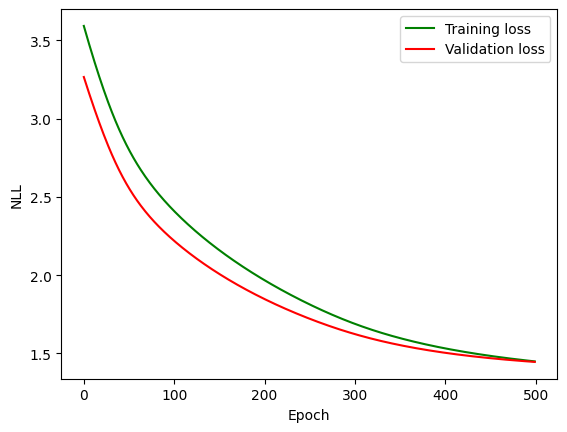

In [ ]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'g', label='Training loss',)
plt.plot(epoch, validation_loss, 'r', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()